We used the fashion MNIST images dataset at a really small scale, rapidly trying out 
different ideas and seeing nuances to explore further.
Time to explore ramping up to the next larger, harder dataset, and check that 
the ideas still hold for longer training runs and more difficult data.
The learnings from Fashion MNIST should move across, most of the time they do, 
but sometimes they don't.
CIFAR10 is used by many/most papers on generative modeling as the smallest dataset.
Most classifications papers track reported results on CIFAR10.
Recent diffusion papers report CIFAR10, then maybe Imagenet, and then 
whatever large massive dataset they're training on.
FastAI in 2018 trained CIFAR10 to .94 classification (the Benchmark) during a competition, 
for a cost of 26 Cents of AWS time, which won the competition.
It is an OK dataset for quickly testing, but also there are reasons why we don't like it,
so we'll soon move on to something better.

In [2]:
import pickle,gzip,math,os,time,shutil,torch,random,logging,accelerate
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from functools import partial

from fastcore.foundation import L
import torchvision.transforms.functional as TF,torch.nn.functional as F
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from diffusers import UNet2DModel

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *
from miniai.accel import *

This notebook is using the same code that Jeremy's going to be looking at and explaining.

In [3]:
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder

mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

The dataset is on Huggingface, we load it like we did the fashion mnist.
The images are 3 Channel RGB rather than single channel so the shape of the data is different.

In [4]:
xl,yl = 'img','label'
name = "cifar10"
dsd = load_dataset(name)

@inplace
def transformi(b): b[xl] = [TF.to_tensor(o)-0.5 for o in b[xl]]

bs = 32
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

Generating train split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset cifar10 downloaded and prepared to /Users/germangoldszmidt/.cache/huggingface/datasets/cifar10/plain_text/1.0.0/447d6ec4733dddd1ce3bb577c7166b986eaa4c538dcd9e805ba61f35674a9de4. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
dt = dls.train
xb,yb = next(iter(dt))

In [6]:
xb[0].shape

torch.Size([3, 32, 32])

Instead of the single channel image we have a 3 Channel red green and blue image,
and this is what a batch of data looks like.
There are 32 images in the batch: batch by Channel by Height by Width.
We can see these are different classes: airplane, a frog, a puzzle with an airplane on the cover,
a bird, a horse, a car, etc. 
Generating these images is quite frustrating.
If we generated this we'd think the model is doing a really bad job,
but that this is a CIFAR10 dog, that is what the data looks like.
A metric that can help, to be shown later, to discern whether it's good, 
as the images are bad, to see how "good" the samples are.
For visually inspecting these CIFAR10 images are not great.

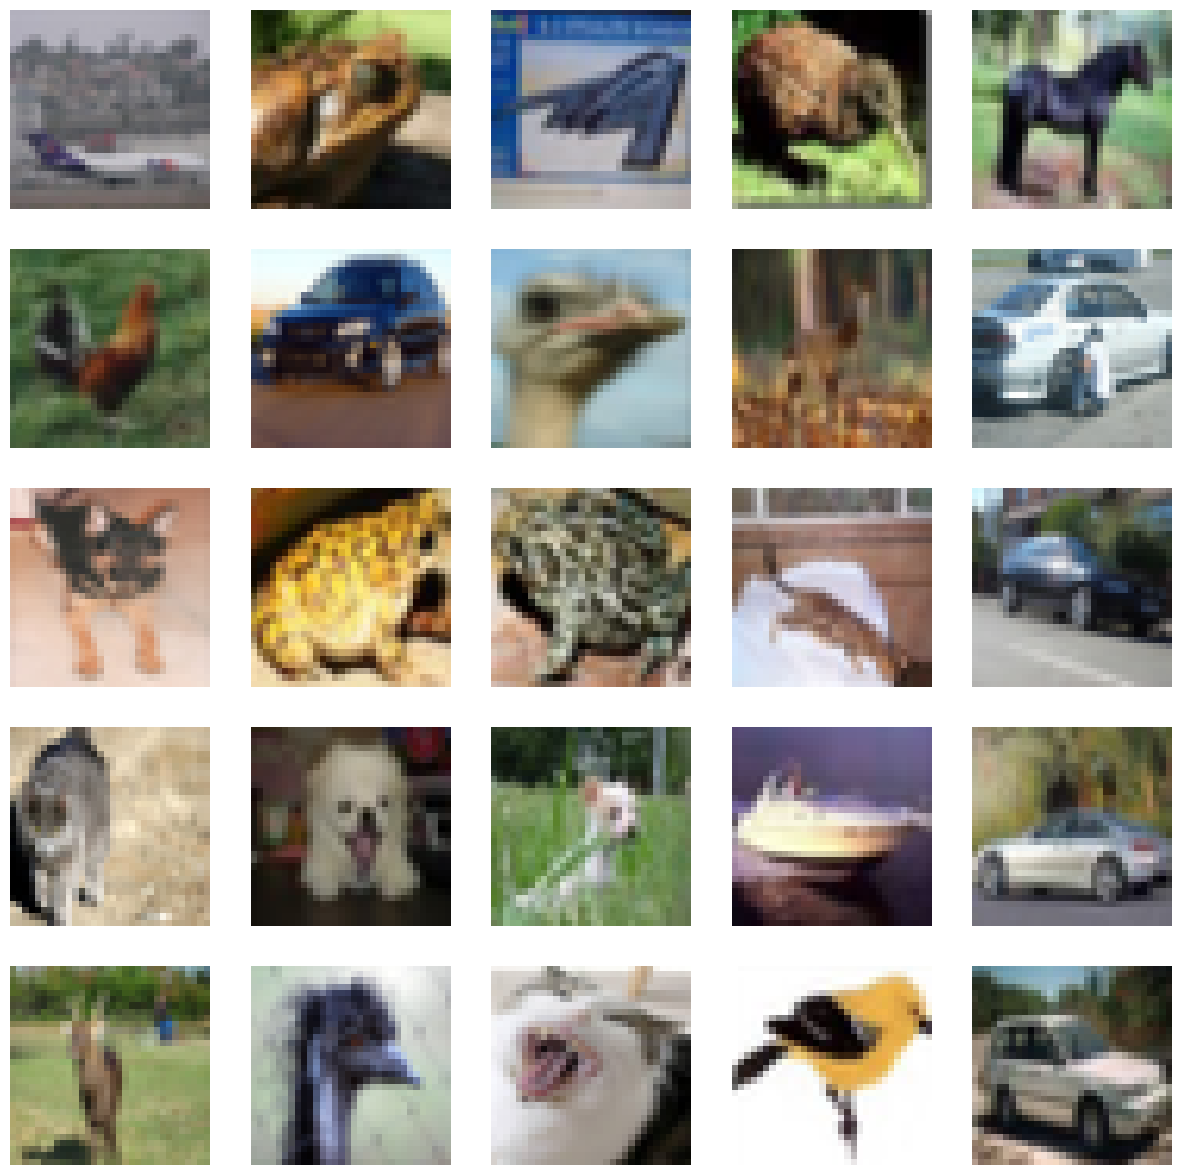

In [7]:
show_images(xb[:25]+0.5)

For the noiseify and everything else following what Jeremy's going to show later.

Because we're adding random noise in the same shape as our data so
even though the data now has three channels the noise apply function still works.

In [8]:
from types import SimpleNamespace
def linear_sched(betamin=0.0001,betamax=0.02,n_steps=1000):
    beta = torch.linspace(betamin, betamax, n_steps)
    return SimpleNamespace(a=1.-beta, abar=(1.-beta).cumprod(dim=0), sig=beta.sqrt())

In [9]:
n_steps = 1000
lin_abar = linear_sched(betamax=0.01)
alphabar = lin_abar.abar
alpha = lin_abar.a
sigma = lin_abar.sig

In [10]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return (xt, t.to(device)), ε

In [11]:
(xt,t),ε = noisify(xb[:25],alphabar)
t

tensor([505, 818,  52, 677,  88, 390, 414,  17,  48,  53, 272,  19, 887, 343,
        275, 506,  22,  79, 889, 719, 543, 974, 602, 258, 377])

If we visualize the noisy images, as we're adding noise on the 3 channels, 
and some have extreme values, they look different, more extreme values in some colors.
But, for example a frog doesn't have as much noise is vaguely visible,
but most are impossible to look at and tell what image is hiding out.

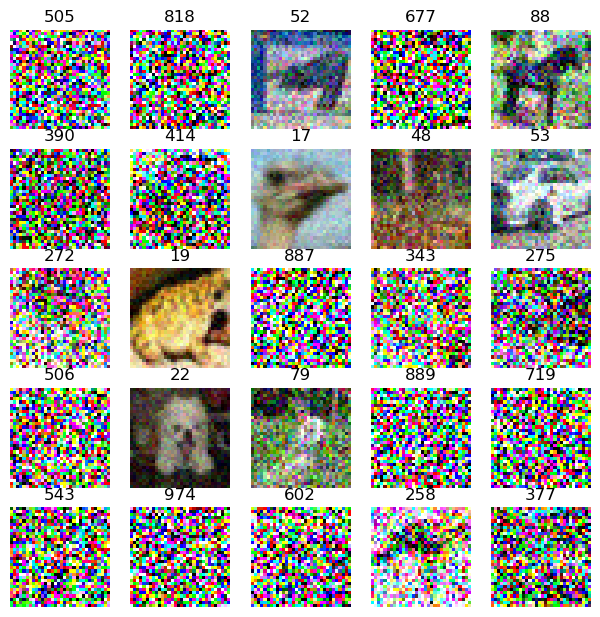

In [12]:
titles = fc.map_ex(t[:25], '{}')
show_images(xt[:25].clip(-0.5, 0.5) + 0.5, imsize=1.5, titles=titles)

# Training

We are paying attention to the broadcasting rules and the right dimensions.
We use the same approach to learning `Unet2DModel`, except that we need to specify 
3 input and 3 output channels. 
We use this demo to justify experiment tracking.

In [13]:
class UNet(UNet2DModel):
    def forward(self, x): return super().forward(*x).sample
    
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers): init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()
    
def collate_ddpm(b): return noisify(default_collate(b)[xl], alphabar)
def dl_ddpm(ds, nw=4): return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=nw)

In [14]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

We bump up the size of the model, from the default settings 
used for fashion MNIST but the diffuser's default Unets have 17x as many parameters:
274M vs 16M.

We're going to try a larger model, some (long-term?) training.

In [19]:
# The model we've been using for FashionMNIST
model = UNet(in_channels=3, out_channels=3, block_out_channels=(32, 64, 128, 256), norm_num_groups=8)
p1 = sum(p.numel() for p in model.parameters())

# The default is a much larger model:
model = UNet(in_channels=3, out_channels=3)
p2 = sum(p.numel() for p in model.parameters())

p1, p2, round(p2/p1)

(15891907, 274056163, 17)

In [20]:
clean_mem() # Free up some memory

We could just do the same training that we've always done just in the notebook,
set up a learner with `ProgressCB` to plot the loss and subtract some metrics.
Waiting for training to finish before we can (DDPM) sample,
we interrupt the training to peek at what it looks like initially, and plot some samples.

In [21]:
lr = 1e-3
epochs = 1
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = UNet(in_channels=3, out_channels=3)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/cuda/amp/grad_scaler.py:118: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


/Users/germangoldszmidt/mambaforge/lib/python3.9/site-packages/torch/amp/autocast_mode.py:202: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


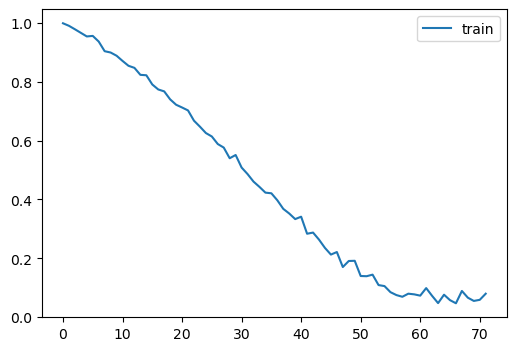


KeyboardInterrupt



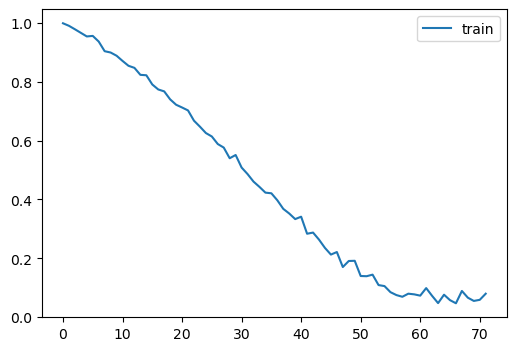

In [22]:
learn.fit(epochs)

The sampling function `sample` works without modification: passing in size `sz`(a 3 Channel image).

In [ ]:
@torch.no_grad()
def sample(model, sz):
    ps = next(model.parameters())
    x_t = torch.randn(sz).to(ps)
    preds = []
    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=ps.device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(ps)
        ᾱ_t1 = alphabar[t-1]  if t > 0 else torch.tensor(1)
        b̄_t = 1-alphabar[t]
        b̄_t1 = 1-ᾱ_t1
        noise = model((x_t, t_batch))
        x_0_hat = ((x_t - b̄_t.sqrt() * noise)/alphabar[t].sqrt())
        x_t = x_0_hat * ᾱ_t1.sqrt()*(1-alpha[t])/b̄_t + x_t * alpha[t].sqrt()*b̄_t1/b̄_t + sigma[t]*z
        preds.append(x_t.float().cpu())
    return preds

In [ ]:
%%time
samples = sample(model, (bs, 3, 32, 32))

In [ ]:
s = (samples[-1] + 0.5).clamp(0,1)
show_images(s[:16], imsize=1.5)

We would like to keep track of what experiments we have tried, and be able to see things over time.
What the samples look like if we generated after the first Epoch after the second Epoch.
That's where the `WandBCB` callback comes.

JH: There are simple ways to do it: (1) save sample images as files every Epoch or two.
(2) Have an updating plot as we train with fastprogress, we could have an updating set of
sample images.
But these wouldn't handle the tracking, looking over time at how 
changes have improved things or made them worse.
That would require saving multiple versions of a notebook or keeping a research journal.
J: A bit lazy sometimes maybe I don't write down what I'm trying, saved too many untitled notebooks..
There are solutions for experiment tracking and logging, e.g., Weights and Biases.

We run a training with an additional `WandBCB` callback, allowing us to log, e.g. samples.
The website [Weights and Biases](http://wandb.ai) is where the callback is sending information to.
Weights and biases accounts are free for personal and academic use.
Sign in, log in, get an authentication token, and then log experiments into different projects.
For each experiment we call `wandb.log()` at any step in the training to send 
to their server and stored, so we can later access and display it.
They have plots that help visualize and can be shared, and 
reports that integrate the data interactively.
You can go and look at a project, and log multiple runs with different settings,
for all that we have tracked, e.g., training loss and validation, learning rate, lr schedule.
We can save a model as an artifact on their server, so we can correlate between the 
exact model code and the logs.

# W&B CB

"save code equals true" creates a copy of the whole Python environment,
libraries installed what code was ran.
It enables to come back later and given some good output (eg images that look good),
retrieve back and see which was the experiment.
There we can check what settings were used, the initialization, configuration details, comments, etc.

We can also create reports for sharing, show results and pull together 
the results from some different runs.
A place where everyone can inspect the different loss curves for any run, e.g., the batch size, etc.
Having a permanent record that someone else deals with storage and the tracking.

This is using the Callback system with wanb.
We start an experiment with `wandb.init()`, specify configurational settings that we used there.
To log use `wandb.log()` passing-in the name and the value.
Here logging the loss and then the value.
When done `wandb.finish()` and that syncs everything up and sends it to the server.

JH: Great the way you've inherited from `MetricsCV` and replaced the 
`_log` that we previously used to allow fastprogress to do the logging,
so now it allows weights and biases to do the logging.

Using the Callback system, wanted to do the things that `MetricCB` normally does,
tracking different metrics, it will still do that,
and we offload to the (super) `MetricsCB` method 
things like the `after_batch`, and in addition to log to the weights and biases.
`before_fit` we initialize the experiments, in every batch we load the loss.
After every epoch the default `MetricsCB` is going to accumulate the metrics, etc., then call `_log()`.
We modify `_log()` to log the current loss during training, 
else to log the validation loss, some samples, weights and biases.
Flexible in terms of what we can log, (images, videos, audio), etc.
It also takes a mathlib figure.

In [ ]:
import wandb

class WandBCB(MetricsCB):
    order=100
    def __init__(self, config, *ms, project='ddpm_cifar10', **metrics):
        fc.store_attr()
        super().__init__(*ms, **metrics)
        
    def before_fit(self, learn): wandb.init(project=self.project, config=self.config)
    def after_fit(self, learn): wandb.finish()

    def _log(self, d): 
        if self.train: 
            wandb.log({'train_'+m:float(d[m]) for m in self.all_metrics})
        else: 
            wandb.log({'val_'+m:float(d[m]) for m in self.all_metrics})
            wandb.log({'samples':self.sample_figure(learn)})
        print(d)

        
    def sample_figure(self, learn):
        with torch.no_grad():
            samples = sample(learn.model, (16, 3, 32, 32))
        s = (samples[-1] + 0.5).clamp(0,1)
        plt.clf()
        fig, axs = get_grid(16)
        for im,ax in zip(s[:16], axs.flat): show_image(im, ax=ax)
        return fig

    def after_batch(self, learn):
        super().after_batch(learn) 
        wandb.log({'loss':learn.loss})

We generate some samples and plot them with `show_image`, 
and return back the figure `fig`, which we can then log.
That becomes these images that we can see over time, every time that log function runs, 
i.e., after every epoch.
Then we can go see what the images look like.

JH: make your code even simpler in the future if we had show images maybe it
could have like a optional return fig parameter that returns the figure,
and then we can replace those 4 lines of code with one.

We can also create a PIL image, make a grid or overlay text, etc.
Then just log that as wandb image.
We pass the callback as an extra callback to the set of callbacks for the learner,
instead of a `MetricCB`.
When we call that `.fit` we still get a progressbar, still get printed out version,
because the `log()` function still prints those metrics.
Instead of watching progress in the notebook we can set it to run disconnect from the server,
take time off and then check on the phone what do the samples look like.

In [ ]:
lr = 1e-3
epochs = 10
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
wandbcb =  WandBCB(config={'lr':lr, 'epochs':epochs, 'comments':'default unet logging test'})
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), wandbcb, BatchSchedCB(sched)]
model = model = UNet(in_channels=3, out_channels=3)
init_ddpm(model)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

They are starting to look like less random nonsense but still not recognizable.
Maybe we need to train for longer that can be the next experiment.
Next we should think of some extra metrics but Jeremy's going to talk about that.

It's worth setting up a bit of infrastructure, to know what were the settings we used,
saving the model so you have the artifact as results, etc.
There are other similar tools to track experiments in lieu of creating many different notebook versions.

In [ ]:
learn.fit(epochs)

JH: 
There are other frameworks: wandb asks to send the info to an external website.
Google's Tensorboard provides similar functionality but it is a server that runs on our computer,
uses a local database.
There are some benefits to have it run as a remote service, e.g., people collaborating on a project.
It's not always the best approach, but there are benefits to using this service.

An alternative point of view, I don't use it or any experiment tracking framework myself.
Maybe I could get some benefits by doing so but I fairly intentionally don't,
because I don't want to make it easy for myself to try a 1000 different hyper parameters.
I like to be very directed, so the workflow I'm looking for is one that allows that to happen.
Constantly going back and refactoring and thinking what did I learn and how do I change
things from here.
Never doing 17 lrs and 6 architectures concurrently.

We can normally have a script that does 100 runs with different models and differences 
and then look at my weights and biases and say filter by the best loss.
Which is very tempting.

JH: Be aware that these tools exist and I in early 2023 weights and biases is the best one,
it has the best integration with fastAI and miniAI.
But do not go crazy on experiments, they have their place, 
but also carefully thought-out hypotheses testing, changing the code,
is the best approach.
